Original data shape: torch.Size([100, 10])
--- Running Standard PCA ---
No trainable layers specified. Using analytical PCA solution.
Transformed data shape (Standard): torch.Size([100, 2])
Explained variance ratio: [0.1723, 0.1450]
Total explained variance: 0.3173
------------------------------

--- Running PCA with 1D Convolution ---
--- Starting Training ---


Loss: 0.000000: 100%|██████████| 500/500 [00:00<00:00, 997.19it/s] 


--- Training Finished ---
Transformed data shape (Conv): torch.Size([100, 2])
Conv layer initialized: Conv1d(10, 10, kernel_size=(21,), stride=(1,), bias=False)
Explained variance ratio: [0.2885, 0.1868]
Total explained variance: 0.4753
------------------------------

--- Running PCA with Fully Connected Layer ---
--- Starting Training ---


Loss: 0.000001: 100%|██████████| 500/500 [00:00<00:00, 779.95it/s]


--- Training Finished ---
Transformed data shape (FC): torch.Size([100, 2])
FC layer initialized: Linear(in_features=10, out_features=100, bias=False)
Explained variance ratio: [0.1422, 0.1375]
Total explained variance: 0.2796
------------------------------

--- Running PCA with Conv and FC (Analytical) ---
ERROR
Explained variance ratio: [0.1716, 0.1461]
Total explained variance: 0.3176
------------------------------

--- Running PCA with TRAINING on Conv and FC layers ---
--- Starting Training ---


Loss: 0.000000: 100%|██████████| 500/500 [00:00<00:00, 722.93it/s]


--- Training Finished ---
Transformed data shape (Trained): torch.Size([100, 2])
Explained variance ratio: [0.2963, 0.1764]
Total explained variance: 0.4727
------------------------------


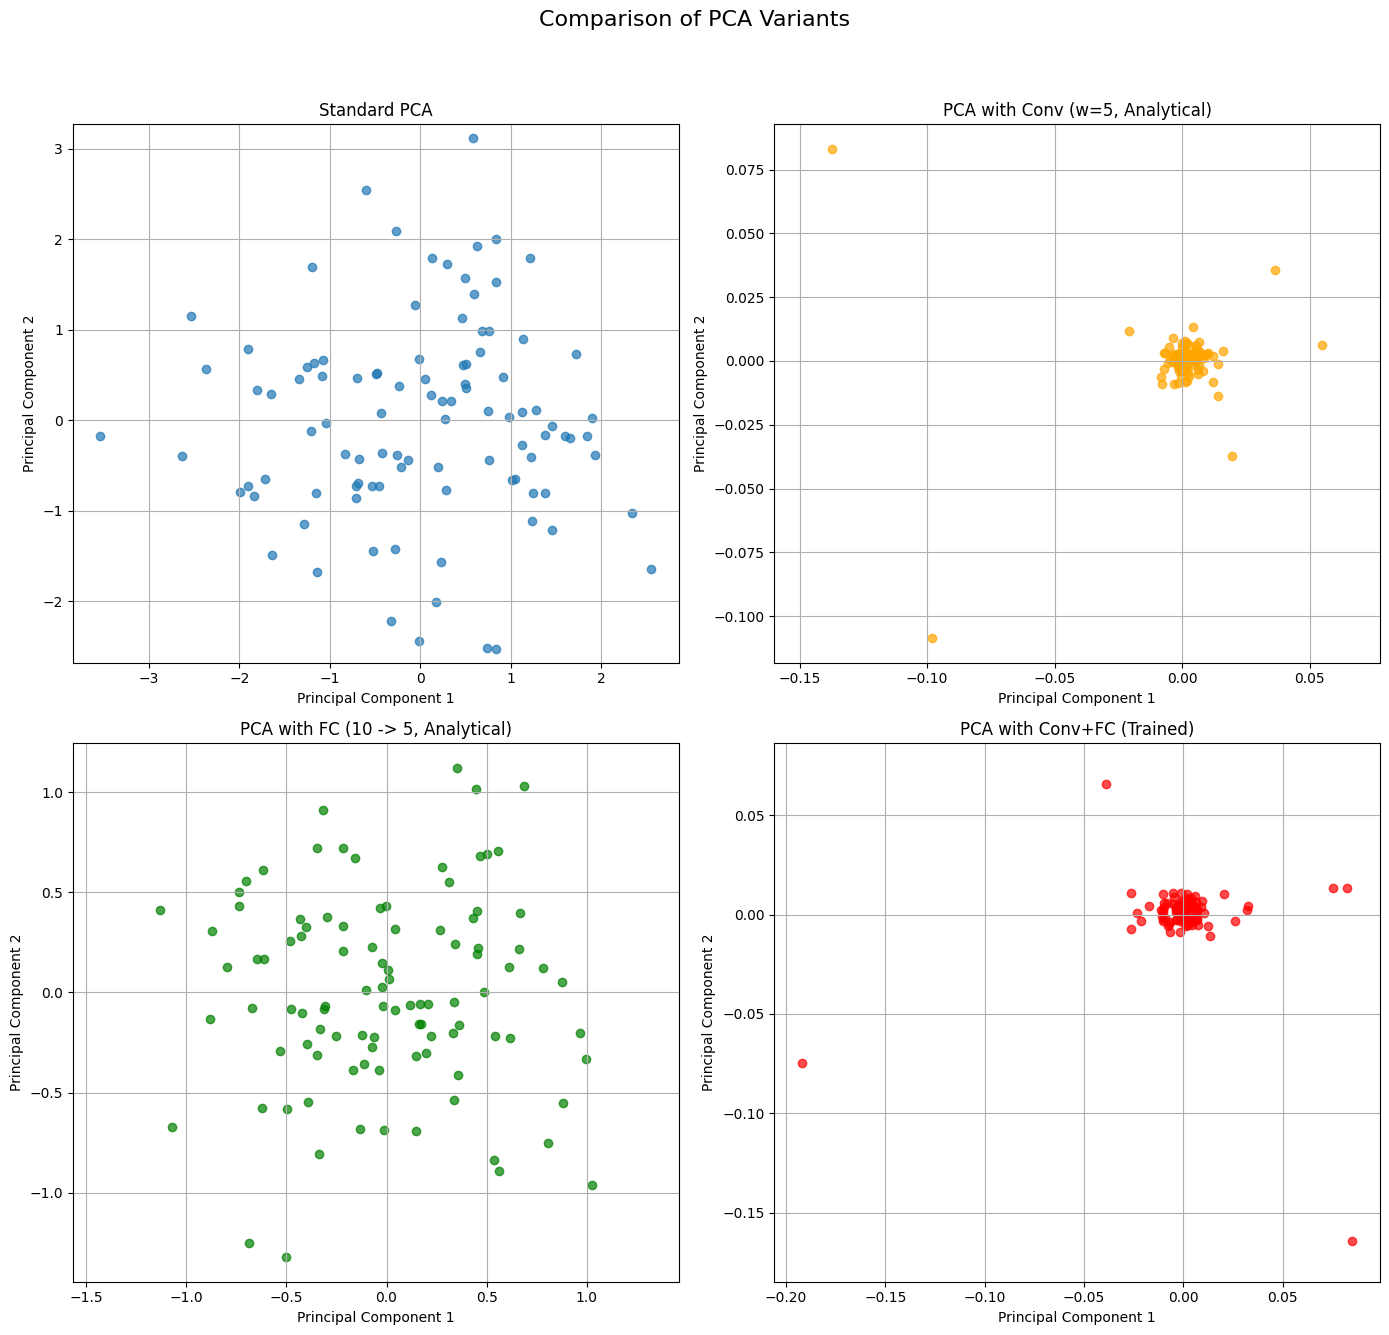

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

class PCA(nn.Module):
    """
    Principal Component Analysis (PCA) implemented using PyTorch, with optional
    pre-processing layers (1D Convolution and Fully Connected) that can be trained.

    This module can be used for standard analytical PCA or can learn a
    pre-processing transformation by minimizing the reconstruction error of the
    covariance matrix of the processed data.

    Parameters
    ----------
    n_components : int
        The number of principal components to keep.
    use_conv : bool, optional (default=False)
        If True, applies a time-series 1D convolution before PCA.
    window_size : int, optional (default=1)
        The window size (kernel size) for the 1D convolution. Used if use_conv is True.
        The convolution is causal (single-sided).
    use_fc : bool, optional (default=False)
        If True, applies a cross-sectional fully connected layer before PCA.
    fc_out_features : int, optional
        The number of output features for the fully connected layer.
        Must be provided if use_fc is True.
    """
    def __init__(self, n_components, use_conv=False, window_size=1, use_fc=False, fc_out_features=None):
        super().__init__()
        self.n_components = n_components
        self.use_conv = use_conv
        self.window_size = window_size
        self.use_fc = use_fc
        self.fc_out_features = fc_out_features

        if self.use_conv and self.window_size <= 0:
            raise ValueError("window_size must be a positive integer if use_conv is True.")
        if self.use_fc and self.fc_out_features is None:
            raise ValueError("fc_out_features must be specified if use_fc is True.")

        # Layers will be initialized in the first call to fit()
        self.conv1d = None
        self.fc_layer = None

        # PCA-specific attributes
        self.mean = None
        self.components = None
        self.eigenvalues = None


    def _initialize_layers(self, X):
        """Initializes the layers based on the input data shape."""
        n_samples, n_features = X.shape
        
        current_features = n_features

        if self.use_conv and self.conv1d is None:
            # Conv1d expects (N, C_in, L), we treat features as channels and samples as length.
            # We use padding to make it a causal convolution, so the output at time t
            # only depends on inputs from t, t-1, ..., t-window_size+1.
            self.conv1d = nn.Conv1d(
                in_channels=n_features,
                out_channels=n_features,
                kernel_size=self.window_size,
                padding=0, # We handle padding manually for causality
                bias=False
            )

        if self.use_fc and self.fc_layer is None:
            # The FC layer is applied to the features at each time step.
            if self.use_conv:
                # If conv is used, FC input features are the output of conv
                # In this setup, conv out_channels == in_channels
                pass # current_features is already correct
            
            self.fc_layer = nn.Linear(
                in_features=current_features,
                out_features=self.fc_out_features,
                bias=False
            )
            current_features = self.fc_out_features


    def _preprocess(self, X):
        """Applies the convolutional and/or fully connected layers."""
        X_processed = X

        if self.use_conv:
            if self.conv1d is None:
                raise RuntimeError("Convolutional layer not initialized. Call fit() first.")
            # Reshape for Conv1d: (n_samples, n_features) -> (1, n_features, n_samples)
            X_conv_in = X_processed.permute(1, 0).unsqueeze(0)
            
            # Apply causal padding at the beginning of the sequence
            causal_padding = self.window_size - 1
            X_padded = F.pad(X_conv_in, (causal_padding, 0))

            # Apply convolution
            X_conv_out = self.conv1d(X_padded)
            
            # Reshape back: (1, n_features, n_samples) -> (n_samples, n_features)
            X_processed = X_conv_out.squeeze(0).permute(1, 0)

        if self.use_fc:
            if self.fc_layer is None:
                raise RuntimeError("Fully connected layer not initialized. Call fit() first.")
            X_processed = self.fc_layer(X_processed)

        return X_processed

    def fit_analytical(self, X):
        """
        Fit the PCA model using the analytical solution (direct eigendecomposition).
        This method does not train any layers.

        Parameters
        ----------
        X : torch.Tensor
            The input data tensor of shape (n_samples, n_features).
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        # Initialize layers on the first run based on input data shape
        self._initialize_layers(X)

        # 1. Apply pre-processing layers (Conv, FC) with their current weights
        X_processed = self._preprocess(X)

        # 2. Center the processed data
        self.mean = torch.mean(X_processed, dim=0)
        X_centered = X_processed - self.mean

        # 3. Compute the covariance matrix
        n_samples = X_centered.shape[0]
        covariance_matrix = (1 / (n_samples - 1)) * torch.matmul(X_centered.T, X_centered)

        # 4. Perform eigendecomposition
        eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)
        
        # 5. Sort eigenvalues and eigenvectors in descending order
        sorted_indices = torch.argsort(eigenvalues, descending=True)
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # 6. Store the principal components and eigenvalues
        self.eigenvalues = sorted_eigenvalues
        self.components = sorted_eigenvectors[:, :self.n_components]
        
        return self

    @property
    def explained_variance_ratio_(self):
        """
        Returns the percentage of variance explained by each of the eigencomponents.
        The values are sorted in descending order.
        """
        if self.eigenvalues is None:
            raise RuntimeError("You must fit the model before accessing explained_variance_ratio_.")
        # Ensure it's a non-zero sum to avoid division by zero
        total_variance = torch.sum(self.eigenvalues)
        if total_variance > 0:
            return self.eigenvalues / total_variance
        return torch.zeros_like(self.eigenvalues)

    @property
    def total_explained_variance_(self):
        """
        Returns the cumulative percentage of variance explained by the selected n_components.
        """
        if self.eigenvalues is None:
            raise RuntimeError("You must fit the model before accessing total_explained_variance_.")
        
        # Get the ratio for all components
        explained_variance_ratios = self.explained_variance_ratio_
        # Sum the ratios for the selected n_components
        return torch.sum(explained_variance_ratios[:self.n_components])


    def fit(self, X, n_epochs=100, learning_rate=1e-3):
        """
        Fit the PCA model by training the pre-processing layers. The objective
        is to minimize the reconstruction error of the covariance matrix.

        If no trainable layers are used (use_conv=False and use_fc=False), this
        method will simply call the analytical solution.

        Parameters
        ----------
        X : torch.Tensor
            The input data tensor of shape (n_samples, n_features).
        n_epochs : int
            The number of training epochs.
        learning_rate : float
            The learning rate for the Adam optimizer.
        """
        if not self.use_conv and not self.use_fc:
            print("No trainable layers specified. Using analytical PCA solution.")
            return self.fit_analytical(X)

        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        self._initialize_layers(X)

        # Collect parameters from the layers that have been defined
        params_to_train = []
        if self.use_conv:
            params_to_train.extend(self.conv1d.parameters())
        if self.use_fc:
            params_to_train.extend(self.fc_layer.parameters())

        optimizer = torch.optim.Adam(params_to_train, lr=learning_rate)
        
        print("--- Starting Training ---")
        progress_bar = trange(n_epochs, desc="Loss: N/A")
        for epoch in progress_bar:
            optimizer.zero_grad()

            # 1. Pre-process the data
            X_processed = self._preprocess(X)
            
            # 2. Center data and compute covariance matrix
            X_centered = X_processed - X_processed.mean(dim=0, keepdim=True)
            n_samples = X_centered.shape[0]
            cov_matrix = (1 / (n_samples - 1)) * torch.matmul(X_centered.T, X_centered)

            # 3. Perform eigendecomposition
            eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
            # eigenvalues[eigenvalues<1e-6] = 0 # sparsity condition
            eigenvalues = torch.where(
                eigenvalues<1e-6,
                torch.tensor(0.0, device=eigenvalues.device, dtype=eigenvalues.dtype),
                eigenvalues
                )
            
            # 4. Reconstruct the covariance matrix from its eigen-components
            # Note: For a symmetric matrix, C = V * diag(L) * V^T
            cov_reconstructed = eigenvectors @ torch.diag(eigenvalues) @ eigenvectors.T
            cov_reconstructed = torch.nan_to_num(cov_reconstructed)

            # 5. Calculate the loss: Frobenius norm of the reconstruction error.
            # This loss encourages the pre-processing layers to learn a transformation
            # that results in a covariance matrix that is well-behaved and can be
            # accurately reconstructed, effectively regularizing its spectral properties.
            loss = torch.linalg.matrix_norm(cov_matrix - cov_reconstructed, ord='fro')
            # loss = torch.nan_to_num(loss) - loss.sum() 

            loss.backward()
            optimizer.step()
            
            progress_bar.set_description(f"Loss: {loss.item():.6f}")
        
        print("--- Training Finished ---")
        # After training, perform one final analytical fit to store the components
        # with the final trained weights.
        return self.fit_analytical(X)


    def transform(self, X):
        """
        Apply dimensionality reduction to X after applying pre-processing layers.

        Parameters
        ----------
        X : torch.Tensor
            The input data tensor of shape (n_samples, n_features).

        Returns
        -------
        torch.Tensor
            The transformed data of shape (n_samples, n_components).
        """
        if self.mean is None or self.components is None:
            raise RuntimeError("You must fit the model before transforming data.")

        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        # 1. Apply the same pre-processing layers
        X_processed = self._preprocess(X)

        # 2. Center the processed data using the stored mean
        X_centered = X_processed - self.mean

        # 3. Project the data onto the principal components
        X_transformed = torch.matmul(X_centered, self.components)

        return X_transformed

    def fit_transform(self, X, **kwargs):
        """
        Fit the model with X and apply the dimensionality reduction on X.
        Passes any keyword arguments to the fit() method.

        Parameters
        ----------
        X : torch.Tensor
            The input data tensor of shape (n_samples, n_features).
        **kwargs :
            Additional arguments for the `fit` method (e.g., n_epochs, learning_rate).

        Returns
        -------
        torch.Tensor
            The transformed data of shape (n_samples, n_components).
        """
        self.fit(X, **kwargs)
        return self.transform(X)


if __name__ == '__main__':
    # --- Example Usage ---
    torch.manual_seed(42)
    base_data = torch.randn(100, 2)
    transformation = torch.randn(2, 10)
    data_10d = base_data @ transformation * 0.1 + torch.randn(100, 10) * 0.9

    print("Original data shape:", data_10d.shape)
    print("=" * 40)

    # --- Case 1: Standard PCA (no pre-processing) ---
    print("--- Running Standard PCA ---")
    pca_standard = PCA(n_components=2)
    data_2d_standard = pca_standard.fit_transform(data_10d)
    print("Transformed data shape (Standard):", data_2d_standard.shape)
    explained_ratio_std = pca_standard.explained_variance_ratio_[:2].detach().numpy()
    total_explained_std = pca_standard.total_explained_variance_.item()
    print(f"Explained variance ratio: [{explained_ratio_std[0]:.4f}, {explained_ratio_std[1]:.4f}]")
    print(f"Total explained variance: {total_explained_std:.4f}")
    print("-" * 30)


    # --- Case 2: PCA with 1D Convolution ---
    print("\n--- Running PCA with 1D Convolution ---")
    # This might learn to smooth or differentiate the time-series data
    # before finding principal components.
    pca_conv = PCA(n_components=2, use_conv=True, window_size=21)
    data_2d_conv = pca_conv.fit_transform(data_10d, n_epochs=500, learning_rate=0.001) # Reduced epochs for faster example
    print("Transformed data shape (Conv):", data_2d_conv.shape)
    # The conv layer is initialized with random weights.
    print(f"Conv layer initialized: {pca_conv.conv1d}")
    explained_ratio_conv = pca_conv.explained_variance_ratio_[:2].detach().numpy()
    total_explained_conv = pca_conv.total_explained_variance_.item()
    print(f"Explained variance ratio: [{explained_ratio_conv[0]:.4f}, {explained_ratio_conv[1]:.4f}]")
    print(f"Total explained variance: {total_explained_conv:.4f}")
    print("-" * 30)


    # --- Case 3: PCA with Fully Connected Layer ---
    print("\n--- Running PCA with Fully Connected Layer ---")
    # This performs a linear transformation (mixing) of features
    # before finding principal components.
    pca_fc = PCA(n_components=2, use_fc=True, fc_out_features=100)
    data_2d_fc = pca_fc.fit_transform(data_10d, n_epochs=500, learning_rate=0.001) # Reduced epochs for faster example
    print("Transformed data shape (FC):", data_2d_fc.shape)
    print(f"FC layer initialized: {pca_fc.fc_layer}")
    explained_ratio_fc = pca_fc.explained_variance_ratio_[:2].detach().numpy()
    total_explained_fc = pca_fc.total_explained_variance_.item()
    print(f"Explained variance ratio: [{explained_ratio_fc[0]:.4f}, {explained_ratio_fc[1]:.4f}]")
    print(f"Total explained variance: {total_explained_fc:.4f}")
    print("-" * 30)


    # --- Case 4: PCA with both Conv and FC ---
    print("\n--- Running PCA with Conv and FC (Analytical) ---")
    pca_both = PCA(n_components=2, use_conv=True, window_size=21, use_fc=True, fc_out_features=100)
    data_2d_both = pca_both.fit_analytical(data_10d) # Use analytical for comparison
    # print("Transformed data shape (Conv+FC):", data_2d_both.shape)
    try:
      print("Transformed data shape (Conv+FC):", data_2d_both.shape)
    except:
      print("ERROR")
    explained_ratio_both = pca_both.explained_variance_ratio_[:2].detach().numpy()
    total_explained_both = pca_both.total_explained_variance_.item()
    print(f"Explained variance ratio: [{explained_ratio_both[0]:.4f}, {explained_ratio_both[1]:.4f}]")
    print(f"Total explained variance: {total_explained_both:.4f}")
    print("-" * 30)

    # --- Case 5: Training the PCA Pre-processing Layers ---
    print("\n--- Running PCA with TRAINING on Conv and FC layers ---")
    pca_trained = PCA(n_components=2, use_conv=True, window_size=21, use_fc=True, fc_out_features=100)
    # The fit method now runs the training loop
    data_2d_trained = pca_trained.fit_transform(data_10d, n_epochs=500, learning_rate=0.001)
    print("Transformed data shape (Trained):", data_2d_trained.shape)
    explained_ratio_trained = pca_trained.explained_variance_ratio_[:2].detach().numpy()
    total_explained_trained = pca_trained.total_explained_variance_.item()
    print(f"Explained variance ratio: [{explained_ratio_trained[0]:.4f}, {explained_ratio_trained[1]:.4f}]")
    print(f"Total explained variance: {total_explained_trained:.4f}")
    print("-" * 30)


    # You can now use `data_2d` for visualization or as input to another model.
    try:
        import matplotlib.pyplot as plt
        # Install tqdm if not present: pip install tqdm
        from tqdm import trange

        fig, axs = plt.subplots(2, 2, figsize=(14, 14))
        fig.suptitle('Comparison of PCA Variants', fontsize=16)

        axs[0, 0].scatter(data_2d_standard[:, 0].detach().numpy(), data_2d_standard[:, 1].detach().numpy(), alpha=0.7)
        axs[0, 0].set_title('Standard PCA')
        
        axs[0, 1].scatter(data_2d_conv[:, 0].detach().numpy(), data_2d_conv[:, 1].detach().numpy(), alpha=0.7, c='orange')
        axs[0, 1].set_title('PCA with Conv (w=5, Analytical)')

        axs[1, 0].scatter(data_2d_fc[:, 0].detach().numpy(), data_2d_fc[:, 1].detach().numpy(), alpha=0.7, c='green')
        axs[1, 0].set_title('PCA with FC (10 -> 5, Analytical)')
        
        axs[1, 1].scatter(data_2d_trained[:, 0].detach().numpy(), data_2d_trained[:, 1].detach().numpy(), alpha=0.7, c='red')
        axs[1, 1].set_title('PCA with Conv+FC (Trained)')
        
        for ax in axs.flat:
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.grid(True)
            ax.axis('equal')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except ImportError:
        print("\nMatplotlib or tqdm not found. Please install them to visualize the results: `pip install matplotlib tqdm`")